<h1 align="center">Inference with Diffusers Library</h1> 

In [1]:
import PIL
import torch
import diffusers
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline
import numpy as np
import matplotlib.pyplot as plt

# suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/chris/miniconda3/envs/diffusers/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Text2Image (`StableDiffusionPipeline`)

In [2]:
pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 573.10it/s]


100%|██████████| 50/50 [00:05<00:00,  9.41it/s]


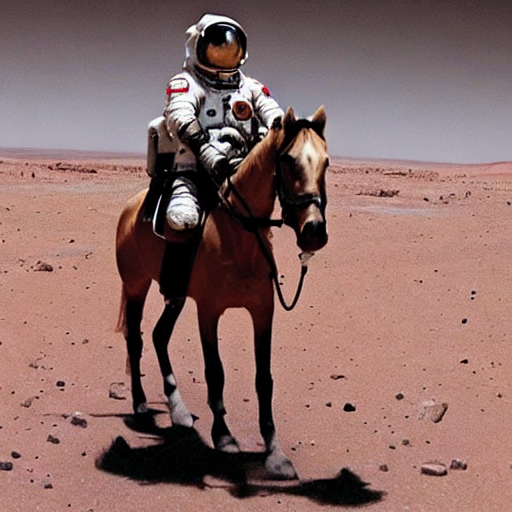

In [3]:
pipeline("a photo of an astronaut riding a horse on mars").images[0]

100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


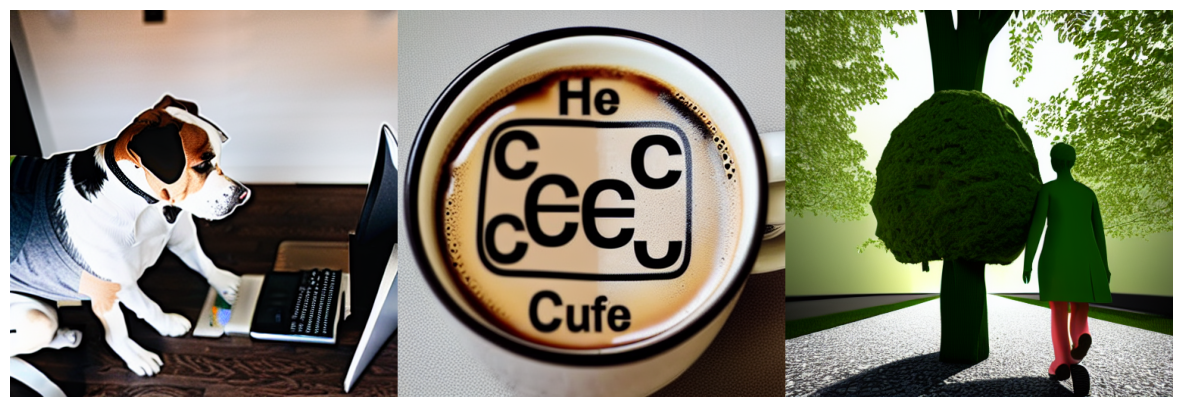

In [4]:

# multiple prompts
prompts = [
    "a photo of a dog working on his computer", 
    "a coffee cup with the periodic table of elements painted on it", 
    "a 3D render of humanoid tree taking a walk with his tree wife"
    ]

# different scheduler
pipeline.scheduler = diffusers.DDPMScheduler.from_config(pipeline.scheduler.config)
num_inference_steps = 150

# guidance_scale
guidance_scale = 12.5

# run inference
ret = pipeline(
    prompts, 
    guidance_scale=guidance_scale, 
    num_inference_steps=num_inference_steps, 
    output_type="np.array"
)

# plot results
plt.figure(figsize=(15, 6))
plt.imshow(np.hstack(ret.images))
plt.axis("off")
plt.show()

# Inpainting (`StableDiffusionInpaintPipeline`)

Let's assume you would like to train a under-age detector detecting children in webcam images. That is quite a challenge as collecting data from minors is challenging, legally and ethically. So let's use stable-diffusion and generate a dataset from children of different ages, gender and ethnicity.

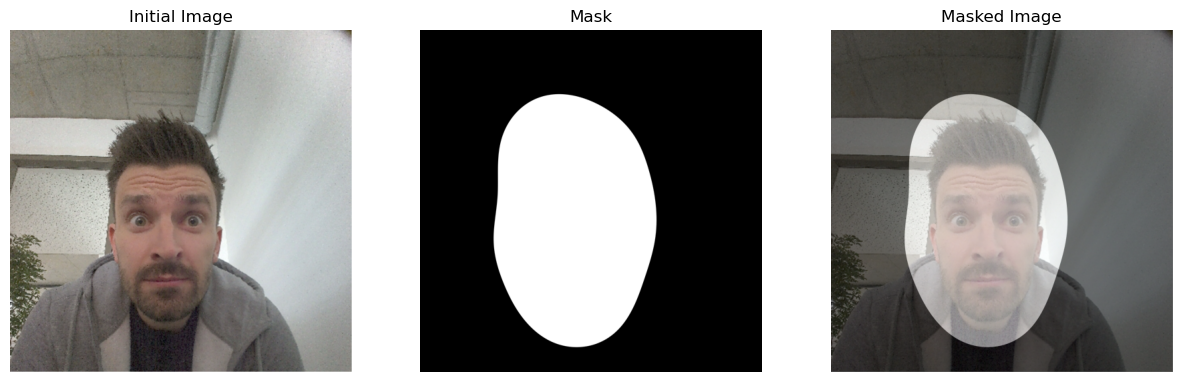

In [5]:
# Input image and mask

init_image = PIL.Image.open("data/chris_capture.jpg").convert("RGB").resize((512, 512))
mask_face = PIL.Image.open("data/chris_mask_face.png").convert("RGB").resize((512, 512))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

ax1.imshow(init_image)
ax1.set_title("Initial Image")
ax1.axis("off")

ax2.imshow(mask_face)
ax2.set_title("Mask")
ax2.axis("off")

ax3.imshow(init_image)
ax3.imshow(mask_face, alpha=0.5)
ax3.set_title("Masked Image")
ax3.axis("off")

plt.show()

In [6]:
# Pipeline
pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 130055.94it/s]


Let's do a first quick run to see it if works...

100%|██████████| 25/25 [00:03<00:00,  6.33it/s]


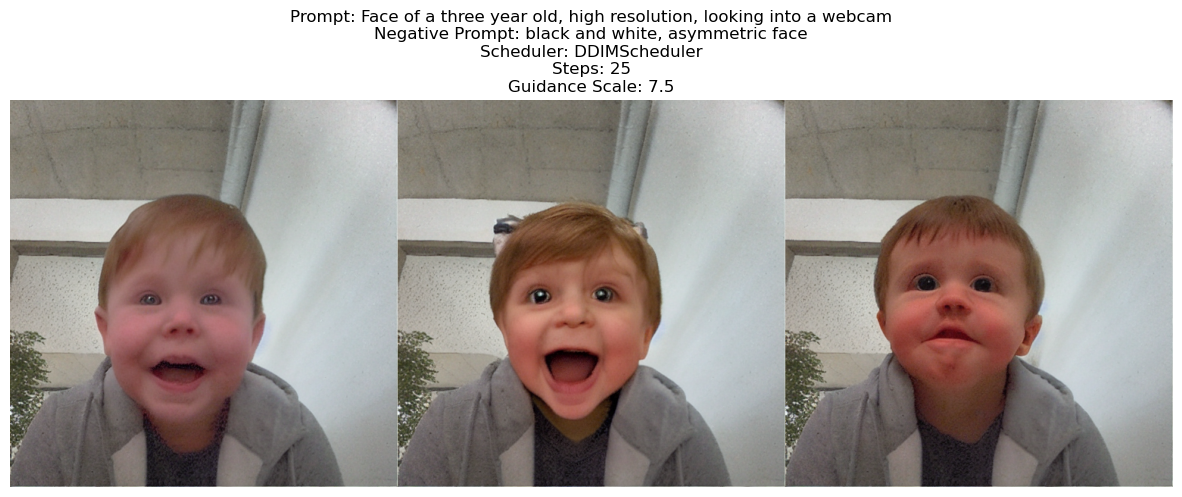

In [7]:
# First quick run with suboptimal settings 

prompt = f"Face of a three year old, high resolution, looking into a webcam"
negative_prompt = "black and white, asymmetric face"
num_inference_steps = 25
guidance_scale = 7.5
args = {
    "prompt": prompt,
    "image": init_image,
    "mask_image": mask_face,
    "negative_prompt": negative_prompt, 
    "num_inference_steps": num_inference_steps,
    "guidance_scale": 7.5,
    "num_images_per_prompt": 3,
    "output_type": "np.array"
}
images = pipeline(**args).images

plt.figure(figsize=(15, 6))
plt.imshow(np.hstack(images))
plt.title(f"Prompt: {prompt}\nNegative Prompt: {negative_prompt}\nScheduler: {pipeline.scheduler._class_name}\nSteps: {num_inference_steps}\nGuidance Scale: {guidance_scale}")
plt.axis("off")
plt.show()

Now, let's experiment with different schedulers and steps to get a feeling for how these parameters affect how photorealistic images look in the end. We'd expect the DDIM scheduler to outperform the others for a low number of steps but to saturate in performance after about 50 steps...

In [8]:
# Testing different schedulers and steps

steps = [25, 50, 100, 150]

schedular_config = pipeline.scheduler.config
schedulers = {
    "DDPM": diffusers.DDPMScheduler.from_config(schedular_config),
    "DDIM": diffusers.DDIMScheduler.from_config(schedular_config),
    "PNDM": diffusers.PNDMScheduler.from_config(schedular_config),
    "Euler": diffusers.EulerDiscreteScheduler.from_config(schedular_config)
}

prompt = "Face of a three year old, high resolution, looking into a webcam"
negative_prompt = "black and white, asymmetric face"

images = dict()
for scheduler_name, scheduler in schedulers.items():
    
    print(f"Running {scheduler_name} scheduler")
    pipeline.scheduler = scheduler
    
    images[scheduler_name] = dict()

    for num_inference_steps in steps:
        ret = pipeline(
            prompt=prompt,
            image=init_image,
            mask_image=mask_face,
            negative_prompt=negative_prompt, 
            num_inference_steps=num_inference_steps,
            guidance_scale=7.5,
            num_images_per_prompt=3,
            output_type="np.array"
        )
        images[scheduler_name][num_inference_steps] = ret.images[0]

Running DDPM scheduler


100%|██████████| 150/150 [00:25<00:00,  5.91it/s]


Running DDIM scheduler


100%|██████████| 150/150 [00:25<00:00,  5.79it/s]


Running PNDM scheduler


100%|██████████| 150/150 [00:26<00:00,  5.65it/s]


Running Euler scheduler


100%|██████████| 150/150 [00:26<00:00,  5.59it/s]


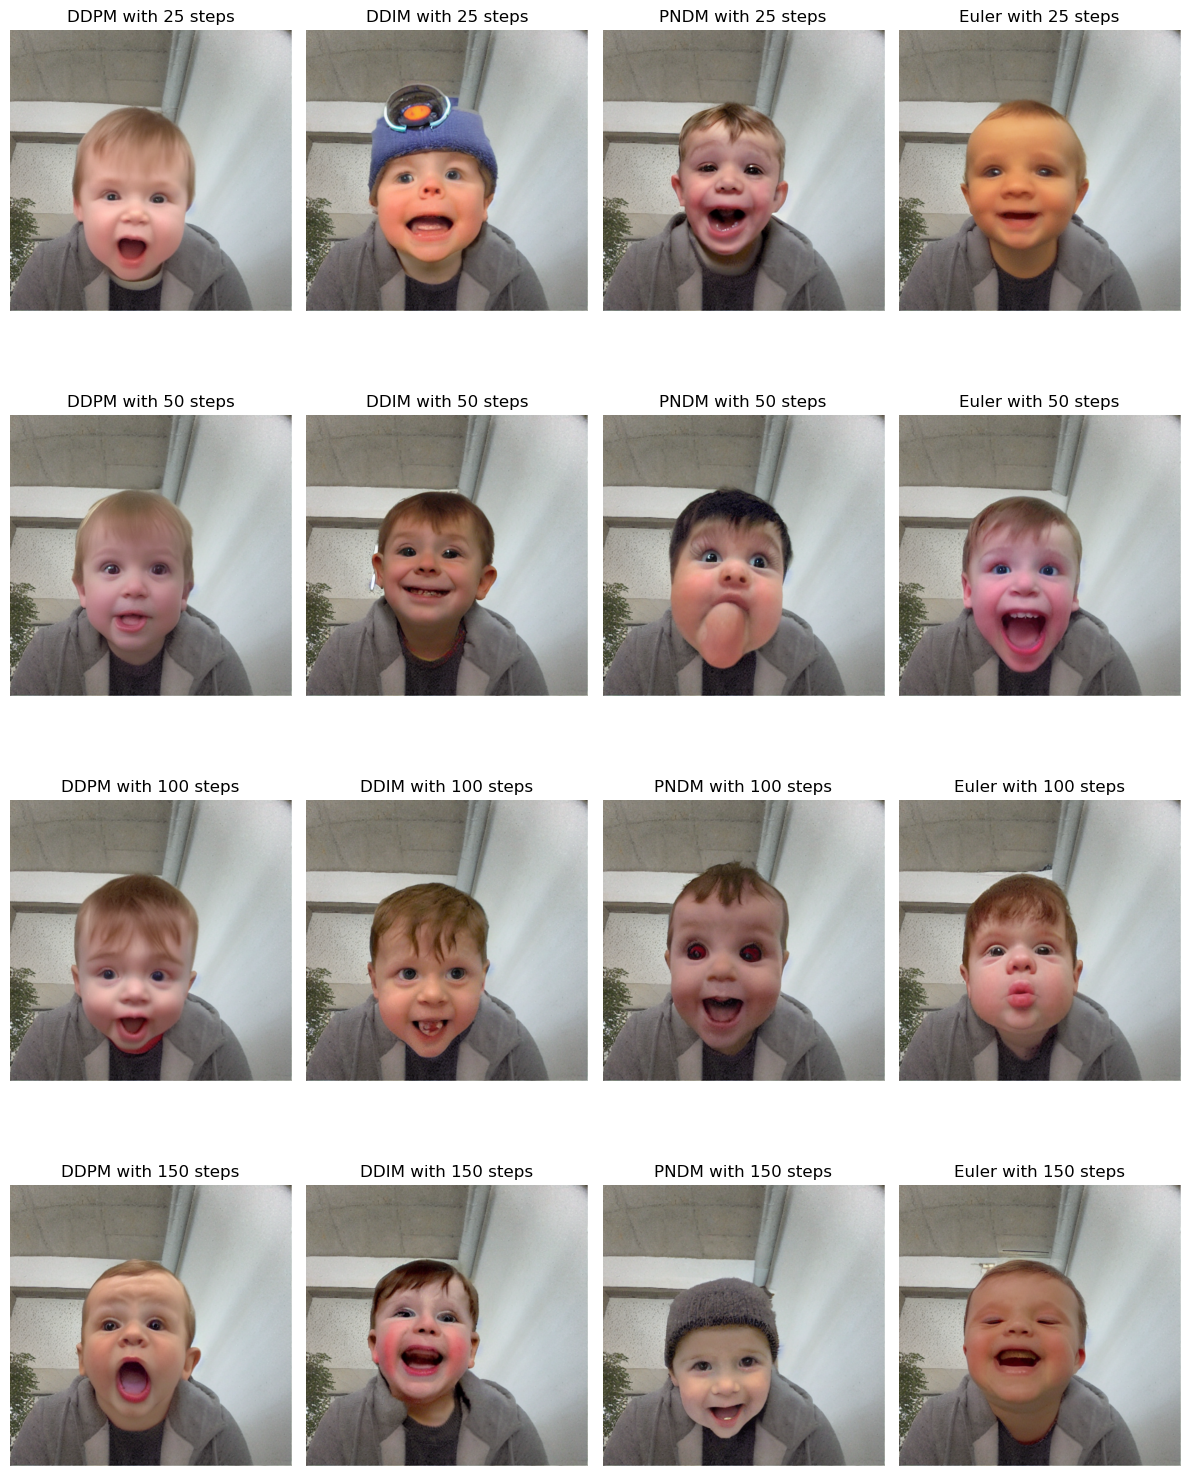

In [9]:
fig, axs = plt.subplots(len(steps), len(schedulers), figsize=(12, len(steps)*4))

for i, scheduler_name in enumerate(schedulers.keys()):
    for j, num_inference_steps in enumerate(steps):
        axs[j, i].imshow(images[scheduler_name][num_inference_steps])
        axs[j, i].set_title(f"{scheduler_name} with {num_inference_steps} steps")
        axs[j, i].axis("off")

plt.tight_layout()
plt.show()


Now let's test the PNDM scheduler with different ages, gender and ethnicities.

In [10]:
pipeline.scheduler = schedulers["DDPM"]

100%|██████████| 150/150 [00:24<00:00,  6.09it/s]


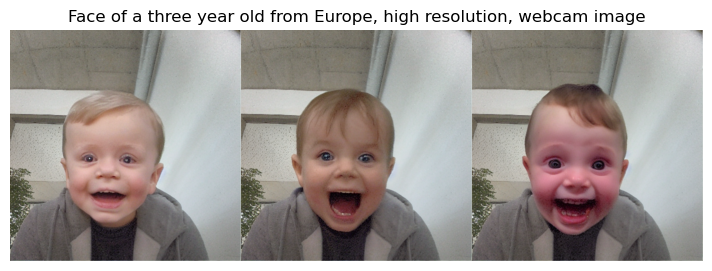

100%|██████████| 150/150 [00:25<00:00,  5.92it/s]


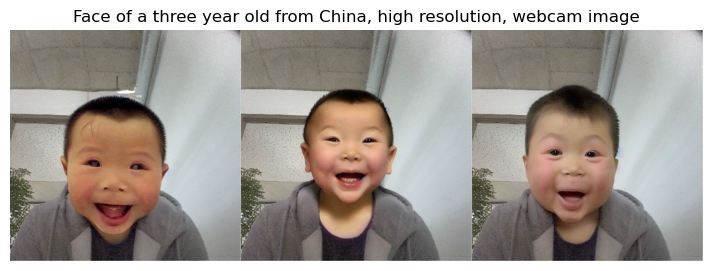

100%|██████████| 150/150 [00:25<00:00,  5.84it/s]


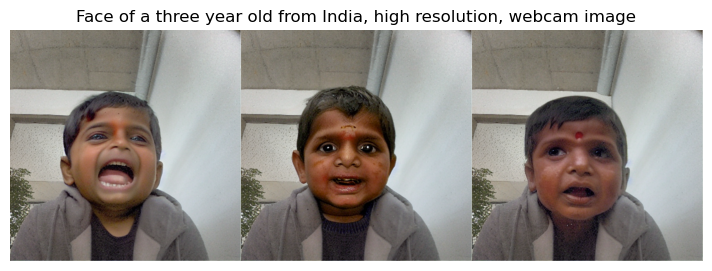

100%|██████████| 150/150 [00:25<00:00,  5.78it/s]


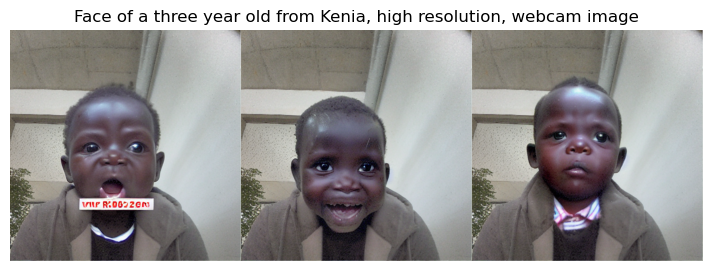

100%|██████████| 150/150 [00:26<00:00,  5.73it/s]


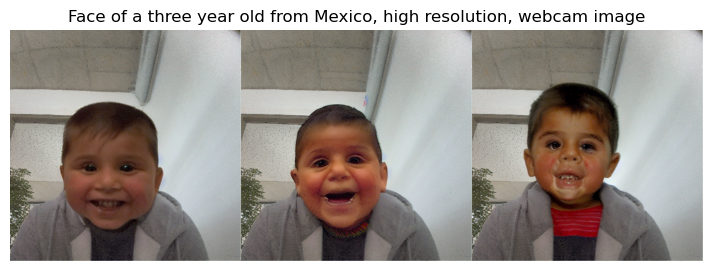

In [11]:

age_and_gender_list = [
    # "two year old", 
    "three year old" , 
    # "five year old girl", 
    # "five year old boy", 
    # "ten year old girl", 
    # "ten year old boy", 
    # "teenage girl"
    # "teenage boy", 
]

countries = [
    "Europe", 
    "China", 
    "India", 
    "Kenia", 
    "Mexico"
]

args = {
    "image": init_image,
    "mask_image": mask_face,
    "negative_prompt":  "black and white, asymmetric face", 
    "num_inference_steps": 150,
    "guidance_scale": 7.5,
    "num_images_per_prompt": 3,
    "output_type": "np.array",
    "generator": [torch.Generator(device="cuda").manual_seed(i) for i in range(3)]
}

for country in countries:
    for age_and_gender in age_and_gender_list:

        prompt = f"Face of a {age_and_gender} from {country}, high resolution, webcam image"
        ret = pipeline(prompt, **args)

        plt.figure(figsize=(10, 3))
        plt.imshow(np.hstack(ret.images))
        plt.title(prompt)
        plt.axis("off")
        plt.show()